In [1]:
# # collab to get connected with drive to save data (optional but beneficial)
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Git cloning the training set

In [2]:
!git clone https://github.com/akhilmhdh/Malayalam---Character---Recognition.git

Cloning into 'Malayalam---Character---Recognition'...
remote: Enumerating objects: 6111, done.
remote: Total 6111 (delta 0), reused 0 (delta 0), pack-reused 6111
Receiving objects: 100% (6111/6111), 54.37 MiB | 28.80 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [0]:
root_drive="Malayalam---Character---Recognition/data"

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets,transforms, models
import os
import numpy as np

# Transforms


In [0]:
data_transform={
    'train':transforms.Compose([transforms.Grayscale(3),
                                  transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
                                    transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])]),
    'valid':transforms.Compose([transforms.Grayscale(3),
                                  transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
                                     ]),
}

In [0]:
train_set=datasets.ImageFolder(root_drive+"/train/",transform=data_transform['train'])
val_set=datasets.ImageFolder(root_drive+"/valid/",transform=data_transform['valid'])

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels=labels.numpy()

# Checking data

Text(0.5, 1.0, '21')

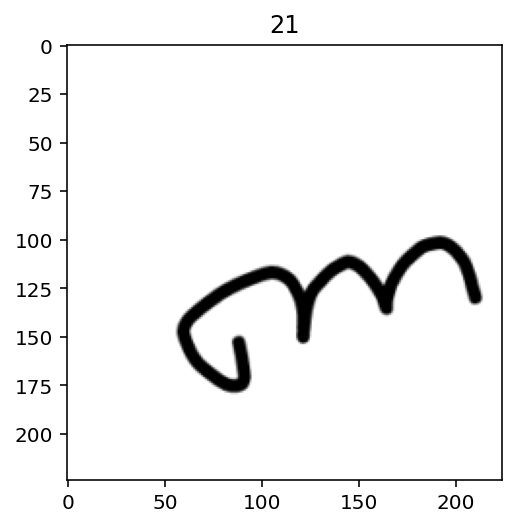

In [9]:
images=np.squeeze(images)
plt.imshow(images[0][0],cmap="gray")
plt.title(labels[0])


In [10]:
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [0]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 48),
                                 nn.LogSoftmax(dim=1))


# Loss Function

In [12]:
train_on_gpu= torch.cuda.is_available()

if train_on_gpu:
    model.cuda()

print(train_on_gpu)

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

True


# Training Function

In [0]:
def train(epochs,model,valid_loss_min):
  for epoch in range(1,epochs+1):
    train_loss=0.0
    valid_loss=0.0

    model.train()

    for data, target in train_loader:
      # moving to cuda
      if train_on_gpu:
        data,target=data.cuda(),target.cuda()
      # clearence gradients
      optimizer.zero_grad()
      # getting output
      output=model(data)
      # getting loss
      loss = criterion(output,target)
      # backpropagation
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*data.size(0)
    
    model.eval()

    for data,target in val_loader:
      if train_on_gpu:
        data,target=data.cuda(),target.cuda()
      
      output=model(data)
      loss=criterion(output,target)

      valid_loss+=loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)

    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss<=valid_loss_min:
       print('Model Save ({:.6f} --> {:.6f})'.format(valid_loss_min,valid_loss))
       torch.save({
           "model":model.state_dict(),
           "valid_loss_min":valid_loss
       },os.path.join("gdrive/My Drive/Colab Notebooks/malayalam-ocr/data/save",'malayalamOCRv3Resnet.pt'))
       valid_loss_min=valid_loss


In [17]:
loadFileName=os.path.join("gdrive/My Drive/Colab Notebooks/malayalam-ocr/data/save",'malayalamOCRv3Resnet.pt')
# loadFileName=None
# valid_loss_min=np.inf

if loadFileName:
  savedState=torch.load(loadFileName)
  modelDict=savedState["model"]
  valid_loss_min=savedState["valid_loss_min"]

epochs=30
if loadFileName:
  model.load_state_dict(modelDict)
train(epochs,model,valid_loss_min)

Epoch: 1 	 Training Loss: 1.148011 	 Validation Loss: 0.544863
Epoch: 2 	 Training Loss: 1.139464 	 Validation Loss: 0.594832
Epoch: 3 	 Training Loss: 1.119493 	 Validation Loss: 0.617660
Epoch: 4 	 Training Loss: 1.150400 	 Validation Loss: 0.572036
Epoch: 5 	 Training Loss: 1.118447 	 Validation Loss: 0.506041
Model Save (0.523863 --> 0.506041)
Epoch: 6 	 Training Loss: 1.146375 	 Validation Loss: 0.560764
Epoch: 7 	 Training Loss: 1.113742 	 Validation Loss: 0.611320
Epoch: 8 	 Training Loss: 1.100638 	 Validation Loss: 0.504697
Model Save (0.506041 --> 0.504697)
Epoch: 9 	 Training Loss: 1.150776 	 Validation Loss: 0.594022
Epoch: 10 	 Training Loss: 1.103888 	 Validation Loss: 0.524974
Epoch: 11 	 Training Loss: 1.090255 	 Validation Loss: 0.557842
Epoch: 12 	 Training Loss: 1.184235 	 Validation Loss: 0.613534
Epoch: 13 	 Training Loss: 1.105430 	 Validation Loss: 0.582118
Epoch: 14 	 Training Loss: 1.093918 	 Validation Loss: 0.609410
Epoch: 15 	 Training Loss: 1.097616 	 Valid